In [22]:
import sympy as sp
from sympy import *
import scipy.optimize as optimize
import numpy as np
from matplotlib import pyplot as plt
from casadi import *
import pandas as pd
import sys

In [23]:

def D(p, params):
    t, ε, κ, c = params
    D_values = κ * p ** -ε
    return D_values

def τ(p, params):
    t, ε, κ, c = params
    sales_revenue = p * D(p, params)
    total_sales_revenue = sum1(sales_revenue)
    taxes_on_total_profits_by_jurisdiction = sales_revenue / total_sales_revenue * t
    return sum1(taxes_on_total_profits_by_jurisdiction)

def before_tax_profits(p, params):
    t, ε, κ, c = params
    return (p - c) * D(p, params)

def after_tax_profits(p, params):
    return sum1((1-τ(p, params))*before_tax_profits(p, params))



In [24]:
def max_profits_casadi(params, x0_vals):

    n_jurisdictions = x0_vals.shape[0]
    p = SX.sym("p", n_jurisdictions)

    x = p
    obj = -after_tax_profits(p, params)

    x0 = DM(x0_vals)

    nlp = {
        "x": x,
        "f": obj,
    }

    print_opt_diagnostics = False
    if print_opt_diagnostics:
        ipopt_print_level = 3
    else:
        ipopt_print_level = 0

    solver = nlpsol("solver", "ipopt", nlp, {
                    "ipopt.print_level": ipopt_print_level, "ipopt.tol": 1e-10, 'print_time': 0})
    solution = solver(
        x0=x0,
    )

    return np.array(solution["x"])


In [25]:
jurisdiction_type_1 = pd.DataFrame([{"t": 0, "ε": 6, "κ": 10, "c": 1}])
jurisdiction_type_2 = pd.DataFrame([{"t": 0.2, "ε": 6, "κ": 10, "c": 1}])

n_jurisdictions_by_type = np.array([1, 3])

test = pd.concat([jurisdiction_type_1, jurisdiction_type_2], ignore_index=True)
all_jurisdictions = test.loc[test.index.repeat(n_jurisdictions_by_type)].reset_index(drop=True)
n_jurisdictions = all_jurisdictions.shape[0]

t = all_jurisdictions["t"].to_numpy()
ε = all_jurisdictions["ε"].to_numpy()
κ = all_jurisdictions["κ"].to_numpy()
c = all_jurisdictions["c"].to_numpy()
params = [t, ε, κ, c]
t1_set = np.linspace(0, 0.4, 51)
p1_set = []
p2_set = []
q1_set = []
q2_set = []
r1_set = []
r2_set = []
π1_set = []
π2_set = []
for i in t1_set:
    params[0][0] = i
    p_opt = max_profits_casadi(params, np.ones((n_jurisdictions, 1)))
    p1_opt = p_opt[0, 0]
    p2_opt = p_opt[1, 0]
    p1_set.append(p1_opt)
    p2_set.append(p2_opt)
    q1_set.append(float(D(p_opt, params)[0, 0]))
    q2_set.append(float(D(p_opt, params)[1, 0]))
    r1_set.append(float((D(p_opt, params)*p_opt)[0, 0]))
    r2_set.append(float((D(p_opt, params)*p_opt)[1, 0]))
    π1_set.append(float(after_tax_profits(p_opt.squeeze(), params)))
    π2_set.append(float(after_tax_profits(p_opt.squeeze(), params)))


[Text(0.5, 1.0, '$π2$')]

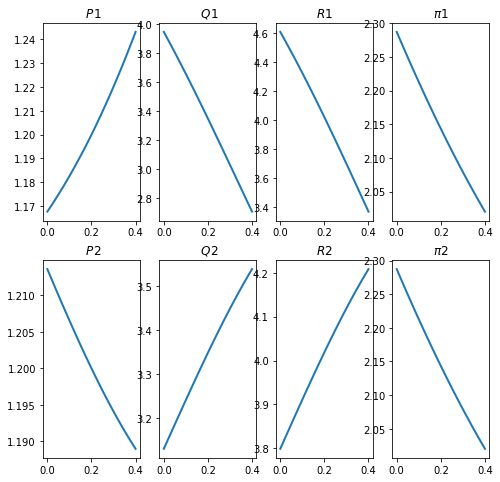

In [26]:
fig, ax = plt.subplots(2,4, figsize=(8, 8))
ax[0,0].plot(t1_set, p1_set, linewidth=2)
ax[0,0].set(title=' $P1$')

ax[1,0].plot(t1_set, p2_set , linewidth=2)
ax[1,0].set(title=' $P2$')

ax[0,1].plot(t1_set, q1_set , linewidth=2)
ax[0,1].set(title=' $Q1$')

ax[1,1].plot(t1_set, q2_set, linewidth=2)
ax[1,1].set(title=' $Q2$')

ax[0,2].plot(t1_set, r1_set, linewidth=2)
ax[0,2].set(title= '$R1$')

ax[1,2].plot(t1_set, r2_set, linewidth=2)
ax[1,2].set(title= '$R2$')

ax[0,3].plot(t1_set, π1_set, linewidth=2)
ax[0,3].set(title= '$π1$')

ax[1,3].plot(t1_set, π2_set, linewidth=2)
ax[1,3].set(title= '$π2$')